# LSTM implementálása PyTorch segítségével
#### [LSTM PyTorch dokumentáció](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)




Szükséges könyvtárak importálása

In [23]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Adatok beolvasása githubról, ha nincs access, akkor a 8. nap/Adatok-ban található a teszt fájl.

In [24]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

--2020-11-25 11:30:51--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360997 (353K) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv.1’

time_series_covid19 100%[===================>] 352.54K  --.-KB/s    in 0.05s   

2020-11-25 11:30:51 (7.55 MB/s) - ‘time_series_covid19_confirmed_global.csv.1’ saved [360997/360997]



Pandas könyvtár segítségével az adatokat beolvassuk.

In [25]:

df = pd.read_csv('time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,40073,40141,40200,40287,40357,40510,40626,40687,40768,40833,40937,41032,41145,41268,41334,41425,41501,41633,41728,41814,41935,41975,42033,42092,42297,42463,42609,42795,42969,43035,43240,43403,43628,43851,44228,44443,44503,44706,44988,45280
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16501,16774,17055,17350,17651,17948,18250,18556,18858,19157,19445,19729,20040,20315,20634,20875,21202,21523,21904,22300,22721,23210,23705,24206,24731,25294,25801,26211,26701,27233,27830,28432,29126,29837,30623,31459,32196,32761,33556,34300
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,53998,54203,54402,54616,54829,55081,55357,55630,55880,56143,56419,56706,57026,57332,57651,57942,58272,58574,58979,59527,60169,60800,61381,62051,62693,63446,64257,65108,65975,66819,67679,68589,69591,70629,71652,72755,73774,74862,75867,77000
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3377,3377,3377,3623,3623,3811,3811,4038,4038,4038,4325,4410,4517,4567,4665,4756,4825,4888,4910,5045,5135,5135,5319,5383,5437,5477,5567,5616,5725,5725,5872,5914,5951,6018,6066,6142,6207,6256,6304,6351
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7222,7462,7622,7829,8049,8338,8582,8829,9026,9381,9644,9871,10074,10269,10558,10805,11035,11228,11577,11813,12102,12223,12335,12433,12680,12816,12953,13053,13228,13374,13451,13615,13818,13922,14134,14267,14413,14493,14634,14742


Kiválogatjuk a Magyarországhoz tartozó adatokat.

In [26]:
df_hun = df.loc[df['Country/Region'] == 'Hungary']

In [27]:
df_hun.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20
143,NaN,Hungary,47.1625,19.5033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,43025,44816,46290,47768,48757,50180,52212,54278,56098,59247,61563,63642,65933,68127,71413,75321,79199,82780,86769,90988,94916,99625,104943,109616,114778,118918,122863,126790,131887,136723,140961,147456,152659,156949,161461,165901,170298,174618,177952,181881


Eldobjuk a nem hasznos változókat.

In [28]:
df_hun = df_hun.iloc[:, 4:]

In [29]:
df_hun.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20
143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,43025,44816,46290,47768,48757,50180,52212,54278,56098,59247,61563,63642,65933,68127,71413,75321,79199,82780,86769,90988,94916,99625,104943,109616,114778,118918,122863,126790,131887,136723,140961,147456,152659,156949,161461,165901,170298,174618,177952,181881


Beállítjuk a dátum típusát.

In [30]:
daily_hu = df_hun.sum(axis = 0)
daily_hu.index = pd.to_datetime(daily_hu.index)

In [31]:
df_hun.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20
143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,43025,44816,46290,47768,48757,50180,52212,54278,56098,59247,61563,63642,65933,68127,71413,75321,79199,82780,86769,90988,94916,99625,104943,109616,114778,118918,122863,126790,131887,136723,140961,147456,152659,156949,161461,165901,170298,174618,177952,181881


Kiszámoljuk a napi esetszámot, mivel egy összegzett esetszám adott.

In [32]:
daily_hu = daily_hu.diff().fillna(daily_hu[0]).astype(np.int64)


In [33]:
print(daily_hu)

2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
              ... 
2020-11-20    4440
2020-11-21    4397
2020-11-22    4320
2020-11-23    3334
2020-11-24    3929
Length: 308, dtype: int64


Ezután normalizáljuk az adatot. (Lehetne MinMaxScalert is használni.)

In [34]:
from sklearn import preprocessing
train = np.expand_dims(daily_hu, axis=1)
scaler = preprocessing.StandardScaler()
train = scaler.fit_transform(train)

Előkészítjük az adatot, a szekvenciákat, hasonlóan, mint az RNN-nél tettük.

In [35]:
def prepare_sequences(data, window):
    input = []
    predicted = []
    for i in range(len(data)-window-1):
        input_i = data[i:(i+window)]
        predicted_i = data[i+window]
        input.append(input_i)
        predicted.append(predicted_i)
    return np.array(input), np.array(predicted)

Definiáljuk az ablak méretét, hogy mekkorák legyenek a szekvenciák, amikből tanulunk.

In [36]:
window = 20
X_train, y_train = prepare_sequences(train, window)

Numpy-ból PyTorch tensorokat képzünk.

In [37]:

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

In [38]:
X_train.shape

torch.Size([287, 20, 1])

Itt következik az LSTM modellünk létrehozása egy osztályban, hogy több réteget tudjunk egyszerre kezelni. A konstruktorban (init) megadjuk, hogy milyen rétegek kövessék egymást. A forward-ban pedig definiáljuk a forward pass-át a hálózatnak, hogy követik egymást a rétegek és hogy mozog az adat a hálózaton előre.

In [47]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, time_window):
    super(LSTM, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers = num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size, 1)
  
  def forward(self, input):
    h_0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
    c_0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
    out, (h_n, c_n) = self.lstm(input, (h_0, c_0));
    h_n = h_n.view(-1, self.hidden_size)
    output = self.fc(h_n)
    return output

Ezután a tanulásra készítjük fel a modellt. Beállítjuk a learning rate-et, ami az optimalizálóhoz kell, a num_epochs tartalmazza, hogy meddig fusson a tanítás.

A loss függvényt mean squared errornak választjuk (MSELoss), a PyTorch-ban rengeteg loss függvény van implementálva.

Majd az Adam optimalizálót definiáljuk, amivel magát az optimalizálást szeretnénk végezni.

In [48]:
num_epochs = 1000
learning_rate = 0.001
input_size = 1
hidden_size = 4
num_layers = 1

lstm = LSTM(input_size, hidden_size, num_layers, window)

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


Ezután jön effektíven a tanítás. Léptetjük minden epochban a hálót, kiszámítjuk a hibát, aminek megfelelően backward lépünk (vagyis tanulunk), az optimalizálót is léptetjük (step).

In [49]:
for epoch in range(num_epochs):
    outputs = lstm(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.38407
Epoch: 100, loss: 1.18272
Epoch: 200, loss: 0.74139
Epoch: 300, loss: 0.38512
Epoch: 400, loss: 0.17705
Epoch: 500, loss: 0.10746
Epoch: 600, loss: 0.06827
Epoch: 700, loss: 0.04799
Epoch: 800, loss: 0.03860
Epoch: 900, loss: 0.03438


Ezután kiértékeljük a modellünket.

In [51]:
print(lstm.eval())

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)


PyTorchból újra numpy alakba alakítjuk az adatot, hogy tudjuk ábrázolni a kimenetet.

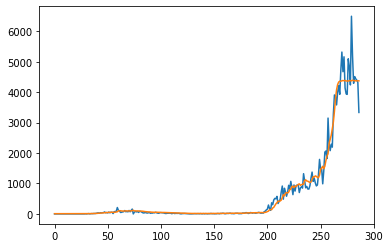

In [50]:
lstm.eval()
train_predict = lstm(X_train)
data_predict = train_predict.data.numpy()
dataY_plot = y_train.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.show()